In [50]:
# compare the data/mc for cluster shape/position, variables used for BDT training
# to make sure the bdt is not just learning about the difference between data/mc

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [51]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2018
category = 0
version = '/v4/v4/'

data_path = '/mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data2018/'+version+'/normalized/'
sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/'
lumi = (5.632467289 +2.572903489 +1.685313225 +3.988453305 +3.068943620 +3.527270568 +8.609721915) * 1000
print("lumi is "+str(round(lumi/1000,2))+" fb-1")
# fpath_bkg['mc_mx55'] = sig_path+"signal_125_55_10m_1pb_weighted.root"
fpath_bkg['mc_mx12'] = sig_path+"signal_125_12_10m_1pb_weighted.root"
# fpath_bkg['mc_all'] = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/signal_all_1pb_weighted.root' #except for mx55 ctau 1
fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root"
    

lumi is 29.09 fb-1


In [52]:
for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

mc_mx12 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/signal_125_12_10m_1pb_weighted.root
[0.02332728 0.69241756 0.6954052  0.6994117  0.70647645]
(128953,)
data /mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/Data2018//v4/v4//normalized/Run2_displacedJetMuonNtupler_V1p12_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root
[29085.074]
(8634529,)


In [53]:
trigger_names_file = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:
trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]


# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET


# load BDT score

In [54]:
# make predictions for test data
import pandas as pd
import pickle

bdt_model = 2
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
if bdt_model == 0:
    model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1.pickle', "rb" ))
elif bdt_model == 1:
    model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs.pickle', "rb" ))
else:
    
    model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi.pickle', "rb" ))

    
#     model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_noXYSpread.pickle', "rb" ))




# y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
# print (y_pred)
# y_pred_train = model.predict_proba(x_train)[:, 1]
# y_pred_bkg = model.predict_proba(df_bkg.values)[:, 1]
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))



In [80]:
%%time

start_t = time.time()
jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
npv = {}
npu = {}
nJets = {}
nJets_50gev = {}
jetPt = {}
jetPhi = {}
jetEta = {}
metPhi = {}
met = {}
jetMet_dPhiMin4 = {}

cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterZSpread = {}
cscRechitClusterEtaSpread = {}
cscRechitClusterPhiSpread = {}
cscRechitClusterEtaPhiSpread = {}

cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterNStation = {}

bdt_score = {}

keys = ['mc_signal', 'mc_bkg', 'data']
keys = ['mc_mx55_signal', 'mc_mx55_bkg','mc_mx12_signal', 'mc_mx12_bkg', 'data']
keys = ['mc_mx12_signal', 'mc_mx12_bkg', 'data']
# keys = ['mc_mx55_signal', 'mc_mx55_bkg', 'data']

# keys = ['mc_mx12_signal', 'data']


# keys = ['mc_ctau10_signal', 'mc_ctau10_bkg','data']
# keys = ['mc_all_signal', 'mc_all_bkg','data']




for k in keys:
    if k[:2] == 'mc':
        T = tree_bkg[k[:7]]
    else:
        T = tree_bkg['data']
        
    if 'signal' in k:
        sel_cluster = T.array('cscRechitCluster_match_gLLP') == True
    else:
        sel_cluster = T.array('cscRechitClusterTime') < -12.5
        print("cluster selection efficiency:", np.count_nonzero(sel_cluster.flatten())/len(sel_cluster.flatten()))
        if 'mc' in k: 
#             sel_cluster = T.array('cscRechitCluster_match_gLLP') == False
            sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster_match_gLLP') == False)
        print("cluster selection efficiency:", np.count_nonzero(sel_cluster.flatten())/len(sel_cluster.flatten()))
#     if 'signal' in k:
#         sel_cluster = T.array('cscRechitCluster_match_gLLP') == True
#     else:
#         sel_cluster = T.array('cscRechitClusterJetVetoPt') > 20
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitClusterEta')) < 1.5)
    print(np.count_nonzero(sel_cluster.flatten()))
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberPlus11') == 0)
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberPlus12') == 0)
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberMinus11') == 0)
#     sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterNRechitChamberMinus12') == 0)
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitClusterEta')) < 2.1)
    
    
    
#     sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )
#     if tightid: sel_jet = np.logical_and(sel_jet, T.array('jetPassId'))



    
########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
#     sel_ev= np.zeros(hlt[:,0].shape)
#     for tr in trigger_paths:            
#         sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
#         print("trigger",tr,1.0*np.count_nonzero(hlt[:,tr])/len(hlt[:,tr]))
#     sel_ev = np.logical_and(sel_ev, T.array('category') == category)
    sel_ev = np.logical_and(sel_ev, sel_cluster.sum() == 1)
#     sel_ev = np.logical_and(sel_ev, sel_jet.sum()>=1)
#     sel_ev = np.logical_and(sel_ev,T.array('met') > 200)
#     sel_ev = np.logical_and(sel_ev,T.array('nLeptons') == 0)
    if 'signal' in k: sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_csc'), axis = 1) > 0)
   
    if k == 'data':
        sel_ev = np.logical_and(sel_ev, T.array('Flag_HBHENoiseFilter'))
        sel_ev = np.logical_and(sel_ev, T.array('Flag_HBHEIsoNoiseFilter'))
        sel_ev = np.logical_and(sel_ev, T.array('Flag_BadPFMuonFilter'))
        sel_ev = np.logical_and(sel_ev, T.array('Flag_CSCTightHaloFilter'))
        sel_ev = np.logical_and(sel_ev, T.array('Flag_goodVertices'))

#     if 'bkg' in k:
# #         sel_ev = np.logical_and(sel_ev, sel_cluster.sum() == 1)
#         sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 0
#         sel_ev = np.logical_and(sel_ev, sel_cluster.sum() == 1)
#         sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_csc'),axis = 1) == 0)
#         decay_distance0 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,0]**2 + T.array('gLLP_decay_vertex_y')[:,0]**2 + T.array('gLLP_decay_vertex_z')[:,0]**2)
#         decay_distance1 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,1]**2 + T.array('gLLP_decay_vertex_y')[:,1]**2 + T.array('gLLP_decay_vertex_z')[:,1]**2)
#         cond1 = np.logical_and(decay_distance0 < 200, decay_distance1 < 200)
#         cond2 = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')[:,0]) > 1200, np.abs(T.array('gLLP_decay_vertex_z')[:,1]) > 1200)
#         cond3 = np.logical_and(decay_distance0 >= 800, decay_distance1 >= 800)


#         sel_ev = np.logical_and(sel_ev, np.logical_or(cond3, np.logical_or(cond1, cond2)))
# ########### BRANCHES ############

    print("here")
    cscRechitClusterXSpread[k] = T.array('cscRechitClusterXSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterYSpread[k] = T.array('cscRechitClusterYSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZSpread[k] = T.array('cscRechitClusterZSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEtaSpread[k] = T.array('cscRechitClusterEtaSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhiSpread[k] = T.array('cscRechitClusterPhiSpread')[sel_cluster][sel_ev][:,0]

    cscRechitClusterX[k] = T.array('cscRechitClusterX')[sel_cluster][sel_ev][:,0]
    cscRechitClusterY[k] = T.array('cscRechitClusterY')[sel_cluster][sel_ev][:,0]
    cscRechitClusterZ[k] = T.array('cscRechitClusterZ')[sel_cluster][sel_ev][:,0]
    cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_cluster][sel_ev][:,0]
    cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_cluster][sel_ev][:,0]

    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitClusterEtaPhiSpread')[sel_cluster][sel_ev][:,0]
    cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_cluster][sel_ev][:,0]

   ##### cluster-level variables ##### 
    if bdt_model == 0:
        
        bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
         'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
         'cscRechitClusterNStation':cscRechitClusterNStation[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterX':cscRechitClusterX[k],
         'cscRechitClusterY':cscRechitClusterY[k],
         'cscRechitClusterZ':cscRechitClusterZ[k],
        }
    elif bdt_model == 1:
        bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
         'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
         'cscRechitClusterNStation':cscRechitClusterNStation[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterX':np.abs(cscRechitClusterX[k]),
         'cscRechitClusterY':np.abs(cscRechitClusterY[k]),
         'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }
    else:
#         cscRechitClusterX[k] = np.abs(T.array('cscRechitClusterX')[sel_cluster][sel_ev][:,0])
#         cscRechitClusterY[k] = np.abs(T.array('cscRechitClusterY')[sel_cluster][sel_ev][:,0])
#         cscRechitClusterZ[k] = np.abs(T.array('cscRechitClusterZ')[sel_cluster][sel_ev][:,0])
#         cscRechitClusterNStation[k] = np.abs(T.array('cscRechitClusterNStation')[sel_cluster][sel_ev][:,0])

#         bdt_var = {
#          'cscRechitClusterNStation':cscRechitClusterNStation[k],
#          'cscRechitClusterX':cscRechitClusterX[k],
#          'cscRechitClusterY':cscRechitClusterY[k],
#          'cscRechitClusterZ':cscRechitClusterZ[k],
#         }

        bdt_var = {'cscRechitClusterNStation': cscRechitClusterNStation[k],
         'cscRechitClusterEtaSpread': cscRechitClusterEtaSpread[k],
         'cscRechitClusterPhiSpread':cscRechitClusterPhiSpread[k],
         'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
         'cscRechitClusterPhi':cscRechitClusterPhi[k],
         'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
         'cscRechitClusterZ':np.abs(cscRechitClusterZ[k]),
        }


    
    
    

##### bdt variables ####
 
    
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
    print(len(bdt_score[k]) == np.count_nonzero(sel_ev))
#     print("effiency",np.count_nonzero(bdt_score[k]>BDT_CUT)/len(bdt_score[k]))
#     bdt_sel = bdt_score[k] < BDT_CUT 


#     jetPt[k] = T.array('jetPt')[sel_jet][sel_ev][:,0]
#     jetEta[k] = T.array('jetEta')[sel_jet][sel_ev][:,0]
    
    
    met[k] = T.array('met')[sel_ev] 
    metPhi[k] = T.array('metPhi')[sel_ev]
    npv[k] = T.array('npv')[sel_ev]
    weight[k] = T.array('weight')[sel_ev]*lumi
    pileupWeight[k] = T.array('pileupWeight')[sel_ev]
    if k == 'data':
        pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
        weight[k] = weight[k] * 0.0 + 1.0
    
    
#     jetPhi[k] = T.array('jetPhi')[sel_jet][sel_ev][:,0]
#     jetEta[k] = T.array('jetEta')[sel_jet][sel_ev][:,0]
    nJets[k] = T.array('nJets')[sel_ev]
#     jetMet_dPhiMin4[k] = T.array('jetMet_dPhiMin4')[sel_ev]
#     nJets_50gev[k] = T.array('jetPt')[sel_ev]
#     nJets_50gev[k] = nJets_50gev[k][nJets_50gev[k]>=50].count()

    print(k, np.count_nonzero(sel_ev))


3892
here
True
mc_mx12_signal 2851
cluster selection efficiency: 0.12141961616356448
cluster selection efficiency: 0.11958723116983315
1240
here
True
mc_mx12_bkg 1210
cluster selection efficiency: 0.2470005682875927
cluster selection efficiency: 0.2470005682875927
201673
here
True
data 119289
CPU times: user 33.9 s, sys: 2.06 s, total: 36 s
Wall time: 31.3 s


# shape comparison

In [164]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

# Plotting ncsc
start_t = time.time()

logy = 0

rt.gStyle.SetOptFit(1011)
# var = [cscSegClusterX, cscSegClusterY, cscSegClusterZ, cscSegClusterXSpread, cscSegClusterYSpread, cscSegClusterZSpread, cscSegClusterEtaPhiSpread, cscSegClusterNStation]
# title = ['cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'cluster X spread [cm]', 'cluster Y spread [cm]', 'cluster Z spread [cm]', 'cluster #eta-#phi spread', 'N_{station}']
# bins = [[25,0,700],[25,0,700],[25,500,1100],[25,0,90], [25,0,90], [25,0,300], [25,0,0.1], [5,0,5]]
# names = ['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterNStation']

var = [cscSegClusterX, cscSegClusterY, cscSegClusterZ, cscSegClusterNStation]
title = ['cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'N_{station}']
bins = [[25,0,700],[25,0,700],[25,500,1100],[5,0,5]]
names = ['cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterNStation']



key_plot = ['mc_mx55_bkg','data']

for j,v in enumerate(var):
    if not j == 3:continue
    print(j)
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    for i,k in enumerate(keys):
        h[k] = create_TH1D( np.abs(v[k]), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = pileupWeight[k]* weight[k])
#         h[k] = create_TH1D( cscSegClusterYSpread[k], axis_title=['cluster Y spread [cm]', 'Events'], name=k, binning=[25,0,90], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterZSpread[k], axis_title=['cluster Z spread [cm]', 'Events'], name=k, binning=[25,0,300], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterEtaPhiSpread[k], axis_title=['cluster #eta-#phi spread', 'Events'], name=k, binning=[25,0,0.1], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterNStation[k], axis_title=['N_{station}', 'Events'], name=k, binning=[5,0,5], weights = pileupWeight[k]* weight[k])
        h[k].SetLineColor(std_color_list[i])
        if 'bkg' in k: h[k].SetLineColor(std_color_list[i-1])
        if 'data' in k: h[k].SetLineColor(std_color_list[i-3])
        leg.AddEntry(h[k],k)
        if logy: h[k].SetMaximum(h[k].GetMaximum()*10)
        else: h[k].SetMaximum(h[k].GetMaximum()*1.5)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
        h[k].DrawNormalized('same hist')
        h[k].Scale(1./h[k].Integral())
#     c = make_ratio_plot([h['mc_mx55_bkg'],h['data']], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,3])

    c.SetRightMargin(0.05)
    if logy: c.SetLogy()
#     leg.Draw()

    c.Draw()
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_eta2p1_ME1112veto/"+names[j]+".png")
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot/"+names[j]+".png")

# print(time.time()-start_t)

NameError: name 'cscSegClusterX' is not defined

# with ratio plot

0
bdt efficiency data 0.06820410934788623
data 119289
bdt efficiency mc_mx12_bkg 0.18264462809917356
mc_mx12_bkg 1210
1
data 119289
mc_mx12_bkg 1210
2
data 119289
mc_mx12_bkg 1210
3
data 119289
mc_mx12_bkg 1210
4
data 119289
mc_mx12_bkg 1210
5
data 119289
mc_mx12_bkg 1210
6
data 119289
mc_mx12_bkg 1210
7
data 119289
mc_mx12_bkg 1210


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_etaphi/mc_mx12_bkg_bdt_score_withRatio.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_etaphi/mc_mx12_bkg_cscRechitClusterEta_withRatio.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_etaphi/mc_mx12_bkg_cscRechitClusterPhi_withRatio.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file

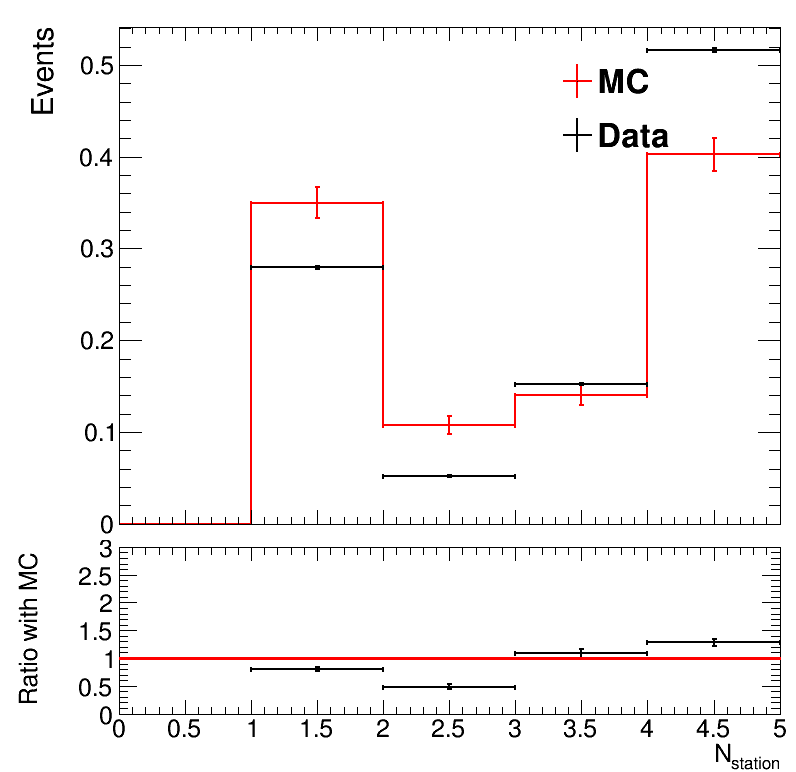

In [97]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

# Plotting ncsc
start_t = time.time()

logy = 0

rt.gStyle.SetOptFit(1011)
if bdt_model <=1 :
    var = [bdt_score, cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, cscRechitClusterXSpread, cscRechitClusterYSpread, cscRechitClusterZSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterNStation]
    title = ['BDT score', 'cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'cluster X spread [cm]', 'cluster Y spread [cm]', 'cluster Z spread [cm]', 'cluster #eta-#phi spread', 'N_{station}']
    bins = [[20,0,1], [25,0,700],[25,0,700],[25,500,1100],[25,0,90], [25,0,90], [25,0,300], [25,0,0.1], [5,0,5]]
    names = ['bdt_score', 'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterXSpread', 'cscRechitClusterYSpread', 'cscRechitClusterZSpread', 'cscRechitClusterEtaPhiSpread', 'cscRechitClusterNStation']
else:
#     var = [bdt_score, cscRechitClusterX, cscRechitClusterY, cscRechitClusterZ, cscRechitClusterNStation]
#     title = ['BDT score', 'cluster X [cm]', 'cluster Y [cm]', 'cluster Z [cm]', 'N_{station}']
#     bins = [[20,0,1], [25,0,700],[25,0,700],[25,500,1100],[5,0,5]]
#     names = ['bdt_score', 'cscRechitClusterX', 'cscRechitClusterY', 'cscRechitClusterZ', 'cscRechitClusterNStation']
    var = [bdt_score, cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterZ, cscRechitClusterEtaSpread, cscRechitClusterPhiSpread, cscRechitClusterEtaPhiSpread, cscRechitClusterNStation]
    title = ['BDT score', 'cluster #eta', 'cluster #phi', 'cluster Z [cm]', 'cluster #eta spread', 'cluster #phi spread', 'cluster #eta-#phi spread', 'N_{station}']
    bins = [[20,0,1], [25,1,2.5],[25,-3.2,3.2],[25,500,1100], [25,0,0.2], [25,0,0.2],[25,0,0.1], [5,0,5],]
    names = ['bdt_score', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterZ',  'cscRechitClusterEtaSpread', 'cscRechitClusterPhiSpread', 'cscRechitClusterEtaPhiSpread','cscRechitClusterNStation']

key_plot = ['data', 'mc_mx55_bkg']
key_plot = ['data', 'mc_mx12_bkg']

# key_plot = ['data', 'mc_mx12_signal']

# key_plot = ['data', 'mc_ctau10_bkg']

# key_plot = ['data', 'mc_all_bkg']

if bdt_model == 1:
    bdt_cut = 0.9227871
else:
    bdt_cut = 0.9608465
for j,v in enumerate(var):
#     if not j == 0:continue
    print(j)
    leg = rt.TLegend(0.55,0.80,0.87,0.90)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)

    h = {}
    for i,k in enumerate(key_plot):
        h[k] = create_TH1D( v[k], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = pileupWeight[k]* weight[k])
#         h[k] = create_TH1D( cscSegClusterYSpread[k], axis_title=['cluster Y spread [cm]', 'Events'], name=k, binning=[25,0,90], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterZSpread[k], axis_title=['cluster Z spread [cm]', 'Events'], name=k, binning=[25,0,300], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterEtaPhiSpread[k], axis_title=['cluster #eta-#phi spread', 'Events'], name=k, binning=[25,0,0.1], weights = pileupWeight[k]* weight[k])
    #     h[k] = create_TH1D( cscSegClusterNStation[k], axis_title=['N_{station}', 'Events'], name=k, binning=[5,0,5], weights = pileupWeight[k]* weight[k])
        h[k].SetLineColor(std_color_list[i])
        if logy: h[k].SetMaximum(h[k].GetMaximum()*10)
        else: h[k].SetMaximum(h[k].GetMaximum()*10)
    #     h[str(i)].SetMinimum(0.1)
        if 'signal' in k: h[k].SetLineStyle(2)
        h[k].GetXaxis().SetLabelSize(0.04)
#         h[k].DrawNormalized('same hist')
        if names[j] == 'bdt_score': print('bdt efficiency', k, np.count_nonzero(v[k]>bdt_cut)/len(v[k]))
        print(k, len(v[k]))
        h[k].Scale(1./h[k].Integral())
    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,3], draw_opt = ['hist E1','E1'])

    c.SetRightMargin(0.05)
    if logy: c.SetLogy()

    c.Draw()
#     c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_eta2p1_ME1112veto/"+names[j]+"_withRatio.png")
#     if bdt_model == 1:
#         c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_abs/mc_mx55_bkg_"+names[j]+"_withRatio.png")
    c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_etaphi/mc_mx12_bkg_"+names[j]+"_withRatio.png")


#     else:
#         c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/MCData_shape_comparison_oot_abs_nospread/mc_mx55_bkg_"+names[j]+"_withRatio.png")

# print(time.time()-start_t)

In [ ]:
# Plotting THStack
lepid=13

color_list = [845,625,597,876,806,861,800,0,1,2]
# color_list = [806,861,]

    
var = [nJets, jetPt, jetPhi, jetEta, met, metPhi, jetMet_dPhiMin4]
xaxis = ['Number of jets', 'leading jet p_{T} [GeV]', 'leading jet #phi', 'leading jet #eta', 'MET [GeV]', 'MET #phi', 'min_{4jet}#Delta#phi(jet, MET)']
names = ['nJets', 'jetPt', 'jetPhi', 'jetEta', 'met', 'metPhi', 'jetMet_dPhiMin4']
bins = [[10,0,10], [50,0,5000], [50,-3.2,3.2], [50,-3,3], [25,0,2000], [50,-3.2,3.2],[50,0,3.2] ]
setlog = [1,1,1,1,1,1,1,1]
var = [cscSegClusterXSpread]
xaxis = ['cluster X spread [cm]']
names = ['cscSegClusterXSpread',]
bins = [[10,0,100] ]
setlog = [1,]
# cscSegClusterXSpread = {}
# cscSegClusterYSpread = {}
# cscSegClusterZSpread = {}
# cscSegClusterEtaPhiSpread = {}
# cscSegClusterNStation = {}



# bkg_keys = ['DYJetsToLL','TTJets_DiLept','QCD','TTJets_SingleLeptFromTbar','TTJets_SingleLeptFromT','WJetsToLNu','ZJetsToNuNu']
for var_i in range(len(var)):
# for var_i in [4]:

#     if not var_i == 4: continue
    c = rt.TCanvas('c','c', 800, 800)
    h = {}
    leg = rt.TLegend(0.60,0.73,0.92,0.92)
    leg.SetTextSize(0.03)
#     leg.SetEntrySeparation(0.008)
    pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 0.99)
    pad1.SetBottomMargin(0.03)
    pad1.SetLeftMargin(0.15)
    # pad1.SetGridx()
    if setlog[var_i]:
        pad1.SetLogy()
    pad1.Draw()
    pad1.cd()

    stack = rt.THStack( "hs" , "Hgg Stack " )
    # var_i =2
    norm = 0
    keys = ['QCD','WJetsToLNu']
#     keys = ['QCD','WJetsToLNu','TTJets']
#     keys = ['QCD','WJetsToLNu','TTJets','ZJetsToNuNu']
#     keys = ['ZJetsToNuNu']

#     keys = ['QCD','WJetsToLNu','TTJets','ZJetsToNuNu_HT-100To200','ZJetsToNuNu_HT-200To400','ZJetsToNuNu_HT-400To600', 'ZJetsToNuNu_HT-600To800',
#             'ZJetsToNuNu_HT-800To1200','ZJetsToNuNu_HT-1200To2500','ZJetsToNuNu_HT-2500ToInf', ]
    sig_keys = ['data']
#     ewtt_keys = ['TTJets_DiLept','TTJets_SingleLeptFromTbar','TTJets_SingleLeptFromT','DYJetsToLL']
    # keys = ['WJetsToLNu','WJetsToLNu_old']
   
    for i,k in enumerate(keys):
        v = var[var_i][k]
        v = v
        w =weight[k] +  v * 0.0

        w = (pileupWeight[k]* weight[k]) +  v * 0.0
        v = v.flatten()
        w = w.flatten()
        v = v[w<8000000]
        w = w[w<8000000]

        h[k] = create_TH1D( v, axis_title=[xaxis[var_i], 'Events'], name=k, binning=bins[var_i],weights = w)
        stack.Add( h[k])
        h[k].SetLineColor(color_list[i]+3)
        h[k].SetFillColor(color_list[i])
        leg.AddEntry(h[k],k)

    stack.Draw('hist')

    for k in sig_keys:
        v = var[var_i][k]
        v = v.flatten()
        h[k] = create_TH1D( v, axis_title=[xaxis[var_i], 'Events'], name=k, binning=bins[var_i],weights = weight[k].flatten())
        h[k].SetLineColor(std_color_list[0])
        h[k].Draw("E1 same")
        print(h[k].GetBinContent(1),h[k].GetBinContent(2))
        leg.AddEntry(h[k],legend[k])




    leg.Draw()
    stack.GetXaxis().SetTitle("")
    stack.GetXaxis().SetLabelSize(0)
    stack.GetYaxis().SetTitle("Events")
#     c.SetLeftMargin(0.2)
    stack.GetYaxis().SetTitleOffset(1)
    stack.GetYaxis().SetRangeUser(0, 1.5*stack.GetStack().Last().GetMaximum())
    if setlog[var_i]:
        stack.SetMinimum(1)
        stack.SetMaximum(100*stack.GetStack().Last().GetMaximum())
# #         stack.GetYaxis().SetRangeUser(1, 100*stack.GetStack().Last().GetMaximum())
        
    c.cd()
    pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.03)
    pad2.SetBottomMargin(0.25)
    pad2.SetLeftMargin(0.15)
    # pad2.SetGrid()
    pad2.Draw()
    pad2.cd()

    h_copy = h['data'].Clone()
    h_copy.Divide(stack.GetStack().Last())
    h_copy.GetYaxis().SetTitleOffset(0.4)
#     h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
    h_copy.GetYaxis().SetTitleSize(0.12)
    h_copy.GetYaxis().SetLabelSize(0.12)
    h_copy.GetYaxis().SetNdivisions(506)
    h_copy.SetMaximum(3)
    h_copy.SetMinimum(0)



    h_copy.GetXaxis().SetTitleOffset(1)
    h_copy.GetXaxis().SetTitleSize(0.12)
    h_copy.GetXaxis().SetLabelSize(0.12)
    h_copy.GetXaxis().SetTickSize(0.07)
    h_copy.SetYTitle('Ratio with {}'.format('MC'))
    h_copy.SetTitle("")
#        h.SetStats(0)
    h_copy.DrawCopy('E1')
    pad2.Update()
    
    
    
    CMS_lumi.lumi_13TeV = str(round(lumi/1000,2))+" fb^{-1}"
    CMS_lumi.cmsText = ""
    CMS_lumi.relPosY = 0.05
    CMS_lumi.writeExtraText = False
    CMS_lumi.CMS_lumi(c,4,4)

#     if setlog[var_i]: 
#         stack.SetMaximum(max_value*100)
#         if var_i == 6:
#             stack.SetMaximum(max_value*1500)
#         c.SetLogy()
    c.Draw()
#     if tightid:
#         c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/stackplot/"+names[var_i]+"_tightid_jetpt"+str(jetPt_cut)+".png")
#     else:
#         c.SaveAs("/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/stackplot/"+names[var_i]+"_looseid_jetpt"+str(jetPt_cut)+".png")
